In [9]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import shap
from torchvision import transforms, datasets
from tqdm.auto import tqdm
import torch.nn as nn

In [10]:
DATA_DIR_NAME = "./data"  # directory with the dataset
DEVICE_NAME = "cpu"  # depending on hardware capabilities: "cuda", "cpu" or "mps"
SEED = 42  # random seed for reproducibility

# Model
AUTOENCODER_WEIGHTS = "./autoencoder_with_classifier.pth"  # path to the model weights
BATCH_SIZE = 32  # batch size for training
LATENT_DIM = 128  # dimensionality of the latent space
LEARNING_RATE = 1e-3  # learning rate for training
N_EPOCHS = 40  # number of epochs for training
TRAIN_AUTOENCODER = True  # whether to train the model (True) or load the weights (False)

# Feature importance
ALPHA = 0.05  # significance threshold for the visualization of the SHAP mask
MAX_EVALS = 4000  # maximum number of evaluations for the SHAP explainer (higher values lead to higher resolution)

# Prototypes
N_PROTOTYPES = 5  # number of prototypes for each class

In [11]:
torch.manual_seed(SEED)
device = torch.device(DEVICE_NAME)

# Data

In [12]:
transforms_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [13]:
normalize = lambda x: (x - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)) / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

data_dir = Path(DATA_DIR_NAME)

datasets_dict = {name: datasets.ImageFolder(data_dir / name, transform=transforms_pipeline)
                 for name in ["train", "valid", "test"]}

dataloaders_dict = {name: torch.utils.data.DataLoader(datasets_dict[name], batch_size=BATCH_SIZE, shuffle=(name == "train"))
                    for name in datasets_dict}

# Autoencoder with classifier

In [14]:
class AutoencoderWithClassifier(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int = 1) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 56 * 56),
            nn.Unflatten(1, (64, 56, 56)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        logits = self.classifier(latent)
        return reconstruction, logits
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        latent = self.encoder(x)
        logits = self.classifier(latent)
        return logits
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

In [15]:
model = AutoencoderWithClassifier(LATENT_DIM).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

reconstruction_loss_fn = nn.MSELoss()
classification_loss_fn = nn.BCELoss()

In [16]:
if TRAIN_AUTOENCODER:
    model.train()
    for epoch in range(N_EPOCHS):
        total_reconstruction_loss = 0.0
        total_classification_loss = 0.0

        for images, labels in tqdm(dataloaders_dict["train"], desc=f"Epoch {epoch + 1}"):
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()

            reconstructed, logits = model(images)

            reconstruction_loss = reconstruction_loss_fn(reconstructed, images)
            classification_loss = classification_loss_fn(logits, labels)
            loss = reconstruction_loss + classification_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_reconstruction_loss += reconstruction_loss.item()
            total_classification_loss += classification_loss.item()

        print(f"Epoch {epoch + 1}: Reconstruction Loss = {total_reconstruction_loss:.4f}, Classification Loss = {total_classification_loss:.4f}")

    torch.save(model.state_dict(), AUTOENCODER_WEIGHTS)
else:
    model.load_state_dict(torch.load(AUTOENCODER_WEIGHTS))
    model.eval()

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Reconstruction Loss = 1.1909, Classification Loss = 9.3832


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: Reconstruction Loss = 0.9877, Classification Loss = 5.2048


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: Reconstruction Loss = 0.9363, Classification Loss = 3.5918


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: Reconstruction Loss = 0.8958, Classification Loss = 1.9121


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5: Reconstruction Loss = 0.8243, Classification Loss = 0.6942


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6: Reconstruction Loss = 0.7584, Classification Loss = 0.1637


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7: Reconstruction Loss = 0.7302, Classification Loss = 0.0309


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8: Reconstruction Loss = 0.6929, Classification Loss = 0.0114


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9: Reconstruction Loss = 0.6634, Classification Loss = 0.0047


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10: Reconstruction Loss = 0.6413, Classification Loss = 0.0033


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11: Reconstruction Loss = 0.6159, Classification Loss = 0.0021


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12: Reconstruction Loss = 0.5920, Classification Loss = 0.0017


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13: Reconstruction Loss = 0.5626, Classification Loss = 0.0011


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14: Reconstruction Loss = 0.5423, Classification Loss = 0.0008


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15: Reconstruction Loss = 0.5203, Classification Loss = 0.0004


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16: Reconstruction Loss = 0.5020, Classification Loss = 0.0003


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17: Reconstruction Loss = 0.4825, Classification Loss = 0.0002


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18: Reconstruction Loss = 0.4739, Classification Loss = 0.0003


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19: Reconstruction Loss = 0.4603, Classification Loss = 0.0001


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20: Reconstruction Loss = 0.4435, Classification Loss = 0.0001


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21: Reconstruction Loss = 0.4265, Classification Loss = 0.0001


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22: Reconstruction Loss = 0.4078, Classification Loss = 0.0001


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23: Reconstruction Loss = 0.3940, Classification Loss = 0.0000


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24: Reconstruction Loss = 0.3789, Classification Loss = 0.0000


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25: Reconstruction Loss = 0.3646, Classification Loss = 0.0001


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26: Reconstruction Loss = 0.3528, Classification Loss = 0.0000


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27: Reconstruction Loss = 0.3410, Classification Loss = 0.0000


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28: Reconstruction Loss = 0.3335, Classification Loss = 0.0000


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29: Reconstruction Loss = 0.3253, Classification Loss = 0.0000


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30: Reconstruction Loss = 0.3079, Classification Loss = 0.0000


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31: Reconstruction Loss = 0.2957, Classification Loss = 0.0000


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32: Reconstruction Loss = 0.2859, Classification Loss = 0.0000


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33: Reconstruction Loss = 0.2746, Classification Loss = 0.0000


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34: Reconstruction Loss = 0.2629, Classification Loss = 0.0000


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35: Reconstruction Loss = 0.2507, Classification Loss = 0.0000


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36: Reconstruction Loss = 0.2391, Classification Loss = 0.0000


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37: Reconstruction Loss = 0.2317, Classification Loss = 0.0000


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38: Reconstruction Loss = 0.2246, Classification Loss = 0.0000


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39: Reconstruction Loss = 0.2146, Classification Loss = 0.0000


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40: Reconstruction Loss = 0.2041, Classification Loss = 0.0000


# Transform data (images, embeddings, labels, predictions)

In [17]:
transformed_data = {}
model.eval()

with torch.no_grad():
    for dataset_name in ["train", "valid", "test"]:
        dataloader = dataloaders_dict[dataset_name]
        images_all, embeddings_all, labels_all, predictions_all = [], [], [], []

        for images, labels in tqdm(dataloader, desc=f"Processing {dataset_name}"):
            images = images.to(device)
            embeddings = model.encode(images)
            predictions = model.predict(images)
            images_all.append(images.cpu())
            embeddings_all.append(embeddings.cpu())
            labels_all.append(labels.cpu())
            predictions_all.append(predictions.cpu())

        transformed_data[f"{dataset_name}_images"] = torch.cat(images_all).numpy().transpose(0, 2, 3, 1)
        transformed_data[f"{dataset_name}_embedding"] = torch.cat(embeddings_all).numpy()
        transformed_data[f"{dataset_name}_y"] = torch.cat(labels_all).numpy()
        transformed_data[f"{dataset_name}_y_hat"] = (torch.cat(predictions_all).numpy() > 0.5).astype(int)

Processing train:   0%|          | 0/10 [00:00<?, ?it/s]

Processing valid:   0%|          | 0/1 [00:00<?, ?it/s]

Processing test:   0%|          | 0/1 [00:00<?, ?it/s]

# Prototypes

In [18]:
x_train = transformed_data["train_embedding"]
y_train = transformed_data["train_y_hat"]

prototypes = {0: [], 1: []}
for cls in (0, 1):
    x_cls = x_train[y_train.flatten() == cls]
    dist_matrix = 1 - np.matmul(x_cls, x_cls.T) / x_cls.shape[1]

    for i in range(N_PROTOTYPES):
        mask = np.in1d(range(dist_matrix.shape[0]), prototypes[cls])
        current_partial_distances = np.minimum.reduce(dist_matrix[mask], axis=0) if prototypes[cls] else np.inf
        candidate_distances = np.minimum(dist_matrix[~mask], current_partial_distances).sum(axis=1)
        idx = np.where(~mask)[0][np.argmin(candidate_distances)].item()
        prototypes[cls].append(idx)

In [19]:
prototypes_data = {cls: [] for cls in (0, 1)} 

for cls in (0, 1):
    for idx in prototypes[cls]:
        image = transformed_data["train_images"][y_train.flatten() == cls][idx]
        embedding = transformed_data["train_embedding"][y_train.flatten() == cls][idx]
        prototypes_data[cls].append({
            "image": image,
            "embedding": embedding
        })

In [112]:
sample_set = "valid"
sample_idx = 0

image = transformed_data[f"{sample_set}_images"][sample_idx]
embedding_sample = transformed_data[f"{sample_set}_embedding"][sample_idx]
cls = transformed_data[f"{sample_set}_y_hat"][sample_idx].item()

In [113]:
max_similarity = 0
nearest_prototype = None
for idx in range(N_PROTOTYPES):
    if (pair_sim := np.dot(prototypes_data[cls][idx]["embedding"].tolist(), embedding_sample.tolist())) > max_similarity:
        max_similarity = pair_sim
        nearest_prototype = prototypes_data[cls][idx]["image"]

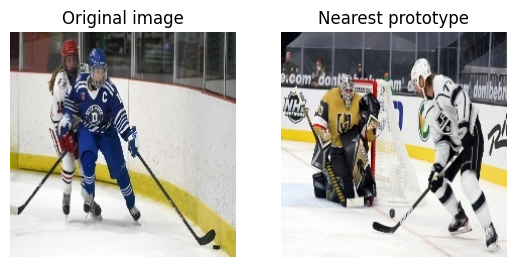

In [114]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
ax[0].set_title("Original image")
ax[0].axis("off")

ax[1].imshow(nearest_prototype)
ax[1].set_title("Nearest prototype")
ax[1].axis("off")

plt.savefig("prototype_hockey_valid_0.png", dpi=300, bbox_inches="tight")

plt.show()

# Feature importance

In [115]:
sample_set = "valid"
sample_idx = 0

image = transformed_data[f"{sample_set}_images"][sample_idx]

In [116]:
def f(x: np.ndarray) -> float:
    x = torch.tensor(x).permute(0, 3, 1, 2).float()
    x = normalize(x).to(device)
    with torch.no_grad():
        return model.predict(x).cpu().numpy()


masker_blur = shap.maskers.Image("blur(1024,1024)", transformed_data["train_images"][0].shape)
explainer_blur = shap.Explainer(f, masker_blur, output_names=datasets_dict[sample_set].classes)
shap_values = explainer_blur(np.array([image]), max_evals=MAX_EVALS, batch_size=20, outputs=shap.Explanation.argsort.flip[:4])
cls = transformed_data[f"{sample_set}_y_hat"][sample_idx].item()
mask = shap_values[0, :, :, 0].values.squeeze(-1)

  0%|          | 0/3998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.65s/it]               


Predicted class: hockey


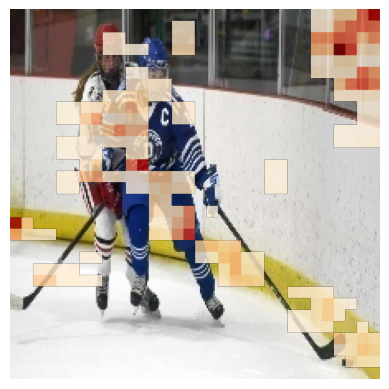

In [117]:
print(f"Predicted class: {datasets_dict[sample_set].classes[cls]}")

if cls == 0:
    mask = -mask
# mask[mask < 0] = 0
mask = mask / mask.max() 
mask[mask < ALPHA] = np.nan


cmap = plt.cm.OrRd

colored_mask = cmap(mask)

plt.imshow(image)
plt.axis("off")
plt.imshow(colored_mask, alpha=0.8)
plt.savefig("shap_hockey_valid_0.png", dpi=300, bbox_inches="tight", pad_inches=0)

wrong classified (bad): index 67